In [1]:
import pandas as pd, numpy as np, seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import phosphodisco as phdc
import os
from itertools import islice
pd.set_option('display.max_columns', 50)
sns.set(style = 'white', color_codes=True, font_scale = 1.3)
matplotlib.rcParams.update({'savefig.bbox': 'tight', 'svg.fonttype':'none'})

In [2]:
def dict_head(mydict, end=1, start=0):
    """
    Analog to pd.DataFrame.head but for python dictionaries.
    Returns the first n key-value pairs of a dict, as a new dict.
    """
    return dict(islice(iter(mydict.items()), start, end))


## Aims
The goal of this notebook is to serve as a tutorial for the core PhosphoDisco workflow.
The first tutorial was [phdc_20200207_running_phdc_regulators_and_annotations.ipynb](phdc_20200207_running_phdc_regulators_and_annotations.ipynb) but it no longer works because a large number of the paths are out of date.

## Design decisions
This tutorial should also serve as the general tutorial for the package, so it will be separated into different notebooks for each section.

Additionally, it should be able to run with just a complete phosphodisco install, i.e. should be able to run without needing to pull in external data. For this purpose I will have to curate and add example data to the package that are small enough to comfortably fit on GitHub and comprehensive enough to demonstrate all of the facets of the package.

## What should be covered
### Short workflow:
1. [x] Run pipeline
2. [x] Pick modules
3. [x] Creating a ProteomicsData object with 
    * phospho
    * normed phospho
    * protein
    * annotations
    * modules
4. [x] calculate_module_scores
5. [x] calculate_annotations_association
6. [x] calculate_go_set_enrichment
7. [x] calculate_regulator_association
8. [x] Peptide analysis
    * [x] collect_aa_sequences
    * [x] Peptide motifs
    * [x] calculate_ptm_set_enrichment
    * [x] Peptide similarity

### Pipeline workflow:
This workflow basically just spells out the step that runs the pipeline of the short workflow:
1. Reading in phospho and  `.gct`, or `.csv` files
2. Remove duplicates
3. normalize_phospho_by_protein
4. Filter by stdev and missingness
5. Correlate normed phospho
6. Run hypercluster
7. Pick clustering

## Running the phosphodisco pipeline
Next we will run the phosphodisco pipeline. It is written in [snakemake](https://snakemake.readthedocs.io/en/stable/) and uses its config conventions.

The pipeline will take in **protein** and **phospho** data, and perform the pre-processing for us, so we can get to **analyzing** the **modules** our phospho data is separated into.

Steps the pipeline performs:
* Reads in protein/ phospho (either .gct or .csv files) - in this case using the same csv files provided via phdc.demo_datasets.load_data
* Removes duplicate proteins/ phosphosites from the phospho and protein data, keeping the row with the least amount of missing data
* Normalizes phospho site data by parent protein abundance
* Filters protein-normalized phospho (normed phospho) for rows below 25% missingness and keeps the rows in the top 50% of standard deviation (cut-offs are adjustable)
* Correlates remaining normed phospho pairwise, and runs hypercluster on correlation matrix to call modules
* Suggests which clustering result to pick based on adjusted Rand score

To run the pipeline, we will:
1. Generate a config file
2. Run the pipeline using said config file


In [3]:
!phdc_generate_config -h

usage: phosphodisco [-h] [--version] [--config_path CONFIG_PATH]
                    [--template {0,1,2}] --phospho PHOSPHO --protein PROTEIN
                    [--min_common_values MIN_COMMON_VALUES]
                    [--top_stdev_quantile TOP_STDEV_QUANTILE]
                    [--na_frac_threshold NA_FRAC_THRESHOLD]

Generates a config file to be used by phdc_run.

optional arguments:
  -h, --help            show this help message and exit
  --version, -v         show program's version number and exit
  --config_path CONFIG_PATH
                        path where config should be output
  --template {0,1,2}    which config template to use - 0 was used for
                        phosphodisco publication, 1 contains additional
                        clustering methods (LouvainCluster and LeidenCluster),
                        2 is the template used for the demo/tutorial
  --phospho PHOSPHO     path to phospho file
  --protein PROTEIN     path to protein file
  --min_common_value

## Generating a config file
We have to provide a `--protein` and `--phospho` argument, even when we are using `--template 2`, which automatically populates those for us with the toy data set used in this tutorial.

If you were using your own data set, you could of course modify the config file after generating one from one of the other two templates (0 or 1), e.g. modifying which parameter sets are used for the clustering part of the pipeline, or the pre-processing.

In [4]:
!phdc_generate_config --template 2 --config_path test_config_demo_phdc.yml --phospho lmao --protein lmao

2022-02-25 20:34:04 WARNING  The following phospho path does not exist: lmao
2022-02-25 20:34:04 WARNING  The following protein path does not exist: lmao


## A test run of the pipeline
Next we will perform a quick `--dry_run` to test if the config works. This does not run anything, just tells you which jobs will be run.

In [5]:
!phdc_run --config_file test_config_demo_phdc.yml --cores 3 --dry_run

2022-02-25 20:34:15 INFO     run()
Runs the snakemake phosphodisco workflow from the command line.
2022-02-25 20:34:15 INFO     command run:
 snakemake --snakefile /gpfs/data/ruggleslab/phosphodisco/phosphodisco/phosphodisco/phdc.smk --cores 3 --configfile test_config_demo_phdc.yml -n -j 20
Building DAG of jobs...
Job stats:
job                         count    min threads    max threads
------------------------  -------  -------------  -------------
all                             1              1              1
choose_cluster                  1              1              1
collect_dfs                     1              1              1
compare_labels                  1              1              1
correlate_phospho               1              1              1
normalize_phospho               1              1              1
read_phospho_and_protein        1              1              1
run_clusterer                  25              1              1
total                          32

## Running the pipeline
Now we can run the pipeline - this should take about 10 minutes on 3 cores, running in local mode.

If you wanted to leverage some kind of scheduler like slurm or SGE, you have to specify the flag  `--cluster_submit_command` --> check -h for an example usage.

In [6]:
!phdc_run --config_file test_config_demo_phdc.yml --cores 3

2022-02-25 20:34:56 INFO     run()
Runs the snakemake phosphodisco workflow from the command line.
2022-02-25 20:34:56 INFO     command run:
 snakemake --snakefile /gpfs/data/ruggleslab/phosphodisco/phosphodisco/phosphodisco/phdc.smk --cores 3 --configfile test_config_demo_phdc.yml -j 20
Building DAG of jobs...
Using shell: /usr/bin/bash
Provided cores: 3
Rules claiming more threads will be scaled down.
Job stats:
job                         count    min threads    max threads
------------------------  -------  -------------  -------------
all                             1              1              1
choose_cluster                  1              1              1
collect_dfs                     1              1              1
compare_labels                  1              1              1
correlate_phospho               1              1              1
normalize_phospho               1              1              1
read_phospho_and_protein        1              1              1
run_cl

In [7]:
!phdc_run -h

2022-02-25 20:39:40 INFO     run()
Runs the snakemake phosphodisco workflow from the command line.
usage: phosphodisco [-h] [--version] --config_file CONFIG_FILE [--cores CORES]
                    [--jobs JOBS] [--cluster_config CLUSTER_CONFIG]
                    [--dry_run]
                    [--cluster_submit_command CLUSTER_SUBMIT_COMMAND]

Runs the snakemake phosphodisco workflow from the command line.

optional arguments:
  -h, --help            show this help message and exit
  --version, -v         show program's version number and exit
  --config_file CONFIG_FILE
                        path to snakemake config file to be used by pipeline.
                        Use phdc_generate_config to geneerate one from a
                        template
  --cores CORES         how many cores to use. default=3
  --jobs JOBS           how many jobs to run at a time. default=20
  --cluster_config CLUSTER_CONFIG
                        snakemake cluster config file
  --dry_run            

## Evaluating the modules generated by the pipeline
The pipeline produces 4 folders of interest:
* clean_phospho
* clustering
    * folder named after input file
        * clustering
            * adjusted_rand_score_label_comparison.pdf </br> PDF file with plot showing the adjusted Rand score matrix for all run clustering algorithm parameter sets
            * adjusted_rand_score_label_comparison.txt </br> matrix used to create the pdf
            * chosen_clusters.txt </br> parameter set chosen based on having the lowest adjusted Rand score
            * labels.txt </br> matrix of module labels, columns are clustering parameter sets, rows are phosphosites
        * clustering_intermediates
            * individual label sets for the parameter sets
* corr_phospho
* normalized_phospho

The [adjusted Rand score](https://en.wikipedia.org/wiki/Rand_index) is a similarity score that we use to compare how similar two sets of module label sets are - i.e. are the same phosphosites ending up together or not?

This metric is useful for finding a consensus set of module labels that best represents the consensus of modules found by different algorithms. 

Ideally, you would find a module set that has a high adjusted Rand score across the board (i.e. a dark line in the matrix plot in the PDF), but occasionally you will find that there is no module set that can explain all other module sets.

In [10]:
!ls clustering/BRCA_v5.2__selected_phospho_0.75frac-no-na.top50frac_stdev.corr/clustering

adjusted_rand_score_label_comparison.pdf  chosen_clusters.txt
adjusted_rand_score_label_comparison.txt  labels.txt


In [11]:
!ls

clean_phospho  normalized_phospho
clustering     phdc_20211116_Tutorial_Core_Phosphodisco_Workflow.ipynb
corr_phospho   test_config_demo_phdc.yml
logs


## Proceeding with module analysis
Since this is a tutorial, for the sake of consistency, we will use the much simpler pre-called modules provided with this package, instead of using the modules we just called using the pipeline.
Though if you are curious, feel free to compare the two sets of modules.

## Making a ProteomicsData object

In **Phosphodisco** everything revolves around the `phosphodisco.classes.ProteomicsData` object.
The ProteomicsData object is used to hold all of the data within one object, so functions can easily be used to access and analyze said data.

Let's first read in the data we need to start:
* protein
* phospho
* normed_phospho
* modules
* annotations

In [12]:
phdc.datasets.list_datasets('demo')

['BRCA_v5.2__module_site_df.csv',
 '.ipynb_checkpoints',
 'BRCA_v5.2__selected_modules.csv',
 'BRCA_v5.2__selected_phospho.csv',
 'BRCA_v5.2__mock_annotations.csv',
 'BRCA_v5.2__selected_annotations.csv',
 'BRCA_v5.2__selected_protein.csv']

In [13]:
modules = phdc.datasets.load_data('demo/BRCA_v5.2__selected_modules.csv', index_col=[0,1])
modules.head(2)

,,HDBSCAN;min_cluster_size-4
gene_symbol,variable_sites_names,
ACTN1,S6s,12
BAZ2A,S1783s,63


In [14]:
phospho = phdc.datasets.load_data('demo/BRCA_v5.2__selected_phospho.csv', index_col=[0,1])
phospho.head(2)

,,X11BR047,X11BR043,X11BR049,X11BR023,X18BR010,X06BR003,X11BR074,X18BR017,X01BR017,X06BR006,X09BR005,X11BR017,X01BR015,X11BR025,X01BR001,X11BR031,X01BR032,X05BR045,X11BR053,X01BR027,X14BR008,X18BR002,X03BR013,X11BR032,X21BR010,...,X06BR014,CPT001846,X18BR016,X05BR005,X13BR009,X11BR080,CPT000814,X01BR042,X15BR003,X14BR014,X11BR058,X11BR012,X01BR009,X01BR008,X21BR001,X21BR002,X01BR026,X05BR004,X03BR006,X01BR023,X01BR020,X20BR006,X09BR001,X03BR011,X01BR010
gene_symbol,variable_sites_names,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ACTN1,S6s,0.2936,-1.9643,-0.9256,-2.6409,-0.8071,-1.6271,-0.2209,-0.3238,3.3634,-0.4123,-0.8764,0.3713,2.5265,-1.9159,4.7032,-1.0035,-2.4233,-1.1491,-2.6852,4.6344,-1.1699,0.6138,-0.7496,-1.1097,-1.3055,...,-1.4833,2.2291,-0.8698,0.8575,-0.7209,-1.9586,2.4453,-0.5397,-1.7290,1.0060,-0.1219,-1.7263,1.5863,-0.6652,-1.4077,-0.6252,2.7589,-0.9871,0.4518,0.2806,2.527,3.8957,-1.2438,-1.0101,0.0602
BAZ2A,S1783s,-1.2947,1.5820,-0.4770,1.5900,-1.0283,-0.4885,-1.1886,-1.0135,1.0415,0.4428,-0.0322,1.1677,1.4091,0.6437,0.3684,1.3175,0.4922,0.2716,-0.5658,1.5397,-1.8825,-1.0778,-1.1292,-1.9827,-2.4033,...,-0.8716,-0.7656,-1.4170,-2.1372,0.5622,0.3827,0.6333,0.4854,-0.9702,-1.5883,0.1799,-0.3733,-0.1113,1.6142,0.6517,-0.7857,-0.4602,-1.3132,1.3633,-0.6044,1.680,0.5886,-1.3409,-0.6894,-0.5041


In [15]:
normed_phospho = pd.read_csv('normalized_phospho/BRCA_v5.2__selected_phospho.normed.csv', index_col=[0,1])
normed_phospho.head(2)

X11BR047  X11BR043  X11BR049  X11BR023  \
gene_symbol variable_sites_names                                           
MAP4K1      S326s                      NaN       NaN  0.077177 -0.263144   
            S171s                      NaN       NaN       NaN  3.060975   

                                  X18BR010  X06BR003  X11BR074  X18BR017  \
gene_symbol variable_sites_names                                           
MAP4K1      S326s                -0.976214 -1.153557 -0.061617  0.473976   
            S171s                -0.390804       NaN       NaN  0.664160   

                                  X01BR017  X06BR006  X09BR005  X11BR017  \
gene_symbol variable_sites_names                                           
MAP4K1      S326s                 0.325217  0.001942 -0.828266  0.246454   
            S171s                      NaN       NaN       NaN       NaN   

                                  X01BR015  X11BR025  X01BR001  X11BR031  \
gene_symbol variable_sites_names                                           
MAP4K1      S326s                -1.021738       NaN  0.287857 -1.350406   
            S171s                 0.273559       NaN       NaN -2.116344   

                                  X01BR032  X05BR045  X11BR053  X01BR027  \
gene_symbol variable_sites_names                                           
MAP4K1      S326s                -0.729363  0.306116 -1.433865       NaN   
            S171s                      NaN       NaN  0.559203       NaN   

                                  X14BR008  X18BR002  X03BR013  X11BR032  \
gene_symbol variable_sites_names                                           
MAP4K1      S326s                 0.858357       NaN       NaN -0.401019   
            S171s                      NaN       NaN       NaN       NaN   

                                  X21BR010  ...  X06BR014  CPT001846  \
gene_symbol variable_sites_names            ...                        
MAP4K1      S326s                -1.685468  ...       NaN        NaN   
            S171s                -1.530490  ...       NaN        NaN   

                                  X18BR016  X05BR005  X13BR009  X11BR080  \
gene_symbol variable_sites_names                                           
MAP4K1      S326s                      NaN       NaN       NaN   1.29139   
            S171s                      NaN       NaN       NaN       NaN   

                                  CPT000814  X01BR042  X15BR003  X14BR014  \
gene_symbol variable_sites_names                                            
MAP4K1      S326s                   0.72352  1.117275  0.820046  0.645945   
            S171s                       NaN       NaN -0.205830       NaN   

                                  X11BR058  X11BR012  X01BR009  X01BR008  \
gene_symbol variable_sites_names                                           
MAP4K1      S326s                 0.343155       NaN -0.426047 -0.188952   
            S171s                 1.042119       NaN -0.565468       NaN   

                                  X21BR001  X21BR002  X01BR026  X05BR004  \
gene_symbol variable_sites_names                                           
MAP4K1      S326s                -0.838053  0.215813 -0.462313  -0.55692   
            S171s                      NaN       NaN       NaN       NaN   

                                  X03BR006  X01BR023  X01BR020  X20BR006  \
gene_symbol variable_sites_names                                           
MAP4K1      S326s                -0.098924  0.405326 -0.221942  0.121383   
            S171s                      NaN       NaN  2.478453  2.094326   

                                  X09BR001  X03BR011  X01BR010  
gene_symbol variable_sites_names                                
MAP4K1      S326s                      NaN  1.387962 -0.094823  
            S171s                      NaN  0.292458       NaN  

[2 rows x 122 columns]

In [16]:
protein = phdc.datasets.load_data('demo/BRCA_v5.2__selected_protein.csv', index_col=[0])
protein.head(2)

,X11BR047,X11BR043,X11BR049,X11BR023,X18BR010,X06BR003,X11BR074,X18BR017,X01BR017,X06BR006,X09BR005,X11BR017,X01BR015,X11BR025,X01BR001,X11BR031,X01BR032,X05BR045,X11BR053,X01BR027,X14BR008,X18BR002,X03BR013,X11BR032,X21BR010,...,X06BR014,CPT001846,X18BR016,X05BR005,X13BR009,X11BR080,CPT000814,X01BR042,X15BR003,X14BR014,X11BR058,X11BR012,X01BR009,X01BR008,X21BR001,X21BR002,X01BR026,X05BR004,X03BR006,X01BR023,X01BR020,X20BR006,X09BR001,X03BR011,X01BR010
gene_symbol,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ACTN1,0.012,-1.5836,-0.1075,-0.7606,1.0471,0.0676,1.6486,1.1374,1.1202,0.7397,1.4048,0.8066,0.9398,-0.6742,0.9586,0.7376,-1.5713,0.2772,-0.1478,1.0151,0.3801,2.4783,1.5465,1.6449,0.0376,...,-0.4078,2.7662,-0.3808,3.2743,0.4743,-0.285,0.5732,-0.4947,0.3211,1.4516,2.4750,-0.9507,1.3995,-0.7236,0.3530,0.5067,2.3206,0.0891,1.0489,-0.6004,0.7953,0.6122,-0.6234,-0.0948,1.6457
BAZ2A,0.159,1.8961,1.4375,0.5705,-0.0640,-0.3186,-0.4151,0.0064,0.4192,-0.2771,1.0159,1.0275,-0.0729,0.0605,0.2989,1.6972,0.1771,0.8307,0.0752,0.1486,-0.1815,-0.5195,-0.6142,0.2026,-0.5384,...,-0.4988,0.0024,-0.5182,0.1587,0.3297,-0.094,-0.0706,0.0858,-1.1698,-0.2762,0.0382,0.3339,0.3593,0.6837,0.8653,0.3045,-0.3180,0.3950,-0.2020,0.6709,0.0975,0.4573,0.4992,0.2245,0.3936


We are using mock_annotations here that were made by adding random normal noise (`categorical_` and `continous_`) to each module score, or just random normal data (`categorical_random`, `continuous_random`).

In [17]:
annotations = phdc.datasets.load_data( 'demo/BRCA_v5.2__mock_annotations.csv', index_col=[0])
annotations.head(2)

,categorical_12,categorical_48,categorical_63,categorical_random_12,categorical_random_48,categorical_random_63,continuous_12,continuous_48,continuous_63,continuous_random_12,continuous_random_48,continuous_random_63
X11BR047,0,1,1,1,1,1,-0.694280,2.288950,1.296663,-0.434632,1.408524,-0.509834
X11BR043,0,1,0,0,1,0,-0.181277,-0.050486,-0.068349,0.406852,-0.238098,0.313678


Let's run the usual PhosphoDisco analyses:

In [18]:
proteomics_obj = phdc.ProteomicsData(
    phospho=phospho, 
    protein=protein,
    normed_phospho=normed_phospho,
    modules=modules,
    annotations=annotations,
    column_types=6*['categorical'] + 6*['continuous'], 

)

## impute_missing_values
This function will impute missing values in the normed_phospho. By default it uses the KNNImputer from sklearn, though you could supply the name of any of the other sklearn imputation methods. 

In [19]:
proteomics_obj.impute_missing_values()

## calculate_module_scores
This function calculates a module score for each sample and each module. This is just taking a simple average of expression of sites within the module.

In [20]:
proteomics_obj.calculate_module_scores()

## calculate_annotation_association
This function calculates the correlation between the module scores and the provided annotations. By default it uses 'pearsonr' for continuous annotations and 'RRA' for categorical annotations.

In [21]:
proteomics_obj.calculate_annotation_association()

## Association of mutations with modules
Let's take a look at which modules were associated with which of our mock annotations:

In [22]:
proteomics_obj.annotation_association_FDR

,continuous_12,continuous_48,continuous_63,continuous_random_12,continuous_random_48,continuous_random_63,categorical_12.0,categorical_12.1,categorical_48.0,categorical_48.1,categorical_63.0,categorical_63.1,categorical_random_12.0,categorical_random_12.1,categorical_random_48.0,categorical_random_48.1,categorical_random_63.0,categorical_random_63.1
HDBSCAN;min_cluster_size-4,,,,,,,,,,,,,,,,,,
12,2.800582e-18,6.477089e-02,3.445595e-03,0.546926,0.556581,0.753633,1.000000,0.011823,0.004975,1.000000,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0
48,4.101137e-01,3.374371e-20,5.939052e-05,0.546926,0.556581,0.890163,0.001282,1.000000,1.000000,0.000174,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0
63,3.407066e-03,2.001518e-06,9.725568e-19,0.546926,0.556581,0.753633,1.000000,1.000000,1.000000,1.000000,1.0,0.003024,1.0,1.0,1.0,1.0,1.0,1.0


In [23]:
cmap = sns.cubehelix_palette(start=0.857, rot=0.00, gamma=1.5, hue=1, light=1, dark=0.2, reverse=False, as_cmap=True)

In [24]:
fdr_threshold = 0.05
df = proteomics_obj.annotation_association_FDR.loc[(proteomics_obj.annotation_association_FDR < fdr_threshold).any(axis=1), (proteomics_obj.annotation_association_FDR < fdr_threshold).any()]

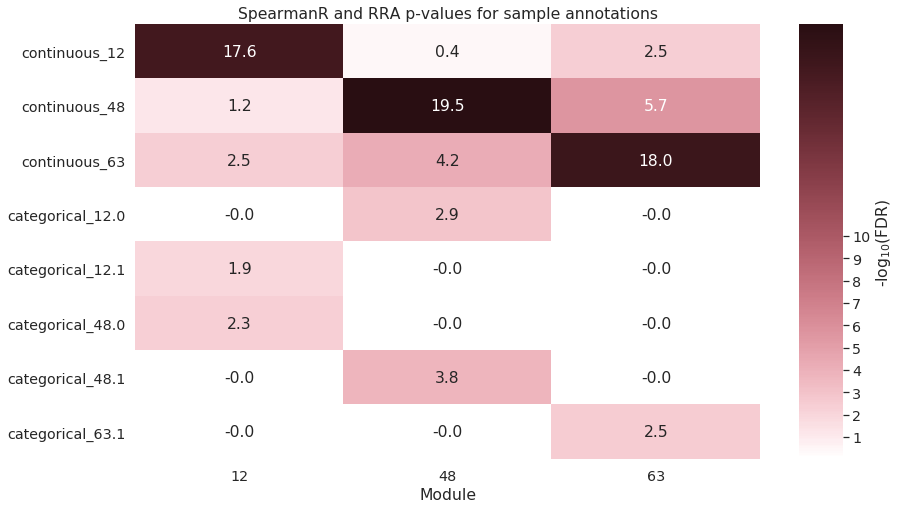

In [25]:
if df.shape[0]!=0:
    fig, ax = plt.subplots(figsize=(14, 8))
    sns.heatmap(
        -np.log10(df).transpose(), 
        xticklabels=[int(i) for i in df.index], yticklabels=df.columns, 
        cmap=cmap,
        cbar_kws=dict(label='-log$_{10}$(FDR)', aspect=10, ticks=range(1, 11)),
        ax=ax,
        annot=True, fmt='.1f',
    )
    plt.xlabel('Module')
    plt.title('SpearmanR and RRA p-values for sample annotations');
else:
    print('No significantly associated annotations')

## calculate_go_set_enrichment
Let's look at which GO-terms are associated with our modules of interest.

For the `gene_set` argument, you can supply any of the gene sets listed on the [Enrichr website](https://maayanlab.cloud/Enrichr/#libraries).

For `background_gene_list`, we take the list of gene symbols for the phosphosites in `normed_phospho`, i.e. for the site `('ABLIM3', 'S607s ')` we would supply `'ABLIM3'`.

In [26]:
proteomics_obj.normed_phospho.index

MultiIndex([( 'MAP4K1',             'S326s '),
            ( 'MAP4K1',             'S171s '),
            ( 'MAP4K1',       'S376s S377s '),
            ( 'MAP4K1',             'S413s '),
            ( 'MAP4K1',             'S421s '),
            ( 'MAP4K1',             'S586s '),
            ( 'MAP4K1', 'Y381y T388t T393t '),
            ( 'SH3BP1',       'S596s S598s '),
            ( 'CAMK2D', 'S280s M281m M282m '),
            ( 'CAMK2D',             'S334s '),
            ...
            ('PRKAR2A',         'T54t S58s '),
            (  'MAP1S',       'S729s S731s '),
            (  'LIMK2',             'S170s '),
            (  'LIMK2',             'S262s '),
            (  'LIMK2',             'S268s '),
            (  'LIMK2',       'S268s S272s '),
            (  'LIMK2',             'S272s '),
            (  'LIMK2',             'S277s '),
            (  'LIMK2',             'T682t '),
            (   'NPR2',             'S523s ')],
           names=['gene_symbol', 'variable_

In [27]:
proteomics_obj.calculate_go_set_enrichment(
    background_gene_list=proteomics_obj.normed_phospho.index.get_level_values(0).unique().to_list(),
    gene_sets=[
#         'GO_Biological_Process_2018', 
        'KEGG_2019_Human', 
        'MSigDB_Oncogenic_Signatures'
    ],
)

2022-02-25 20:41:35,287 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
2022-02-25 20:41:39,765 Warning: No enrich terms using library MSigDB_Oncogenic_Signatures when cutoff = 0.05


Running this function has populated the `go_enrichment` attribute with a dictionary. The keys are modules and the values are DataFrames with GO-terms that matched at least one gene in the module. These DataFrames contain multiple interesting columns, such as the name of the `Gene_set`, the `Genes Overlap` that matched, and the `Adjusted P-value` for randomly finding this overlap.
Let's take a look at the results for module 48:

In [28]:
dict_head(proteomics_obj.go_enrichment, 2, 1)

{48:                                        Gene_set  Genes Overlap  Odds Ratio  \
 Term                                                                         
 RPS14 DN.V1 DN      MSigDB_Oncogenic_Signatures  MKI67   1/187     19813.0   
 CYCLIN D1 UP.V1 UP  MSigDB_Oncogenic_Signatures  MKI67   1/188     19812.0   
 
                     P-value  Adjusted P-value  
 Term                                           
 RPS14 DN.V1 DN      0.00935            0.0094  
 CYCLIN D1 UP.V1 UP  0.00940            0.0094  }

Let's just take a quick peek at how what Adjusted Pvalues look like for GO-term association in the different modules:

In [29]:
pd.concat(
    [
        goterms.sort_values('Adjusted P-value').head().assign(module=mod) for mod, goterms in proteomics_obj.go_enrichment.items()
    ], 
    axis=0
).reset_index().style.format({'Adjusted P-value':'{:,.5f}'})

,Term,Gene_set,Genes,Overlap,Odds Ratio,P-value,Adjusted P-value,module
0,RB DN.V1 UP,MSigDB_Oncogenic_Signatures,MSH6;MRE11A;NUDT5,3/137,63.505330,0.000036,0.00055,12
1,Amoebiasis,KEGG_2019_Human,ACTN1;FN1,2/96,52.914894,0.001001,0.02001,12
2,GCNP SHH UP EARLY.V1 UP,MSigDB_Oncogenic_Signatures,MSH6;MRE11A,2/174,28.805233,0.003235,0.02426,12
3,HINATA NFKB MATRIX,MSigDB_Oncogenic_Signatures,FN1,1/10,246.679012,0.004990,0.02495,12
4,Focal adhesion,KEGG_2019_Human,ACTN1;FN1,2/199,25.118020,0.004206,0.03231,12
5,RPS14 DN.V1 DN,MSigDB_Oncogenic_Signatures,MKI67,1/187,19813.000000,0.009350,0.00940,48
6,CYCLIN D1 UP.V1 UP,MSigDB_Oncogenic_Signatures,MKI67,1/188,19812.000000,0.009400,0.00940,48
7,RNA transport,KEGG_2019_Human,RANBP2;TPR;EIF3H;NUP98,4/165,11.175042,0.000655,0.02031,63
8,EIF4E DN,MSigDB_Oncogenic_Signatures,RANBP2;SVIL;TP53BP1,3/100,13.646048,0.001782,0.07840,63
9,CSR EARLY UP.V1 UP,MSigDB_Oncogenic_Signatures,NCL;DOT1L;HMGA1,3/164,8.195031,0.007146,0.08391,63


Looks like most of the modules have at least a single GO-term that is associated with an adjusted p-value lower than 0.05, except module 3 which has at least 5 such p-values. Let's look at the exact numbers:

## collect_possible_regulators
Next, let's nominate regulators, so we can examine what regulates the modules. I will especially look at modules 3 and 6.

First we have to read in the kinase list via `phdc.data.load_data`:

In [30]:
kinases = phdc.datasets.load_data('kinase_list.tsv', sep='\t', names=[''], squeeze=True).to_list()


In [31]:
proteomics_obj.collect_possible_regulators(possible_regulator_list=kinases)

In [32]:
proteomics_obj.calculate_regulator_association()

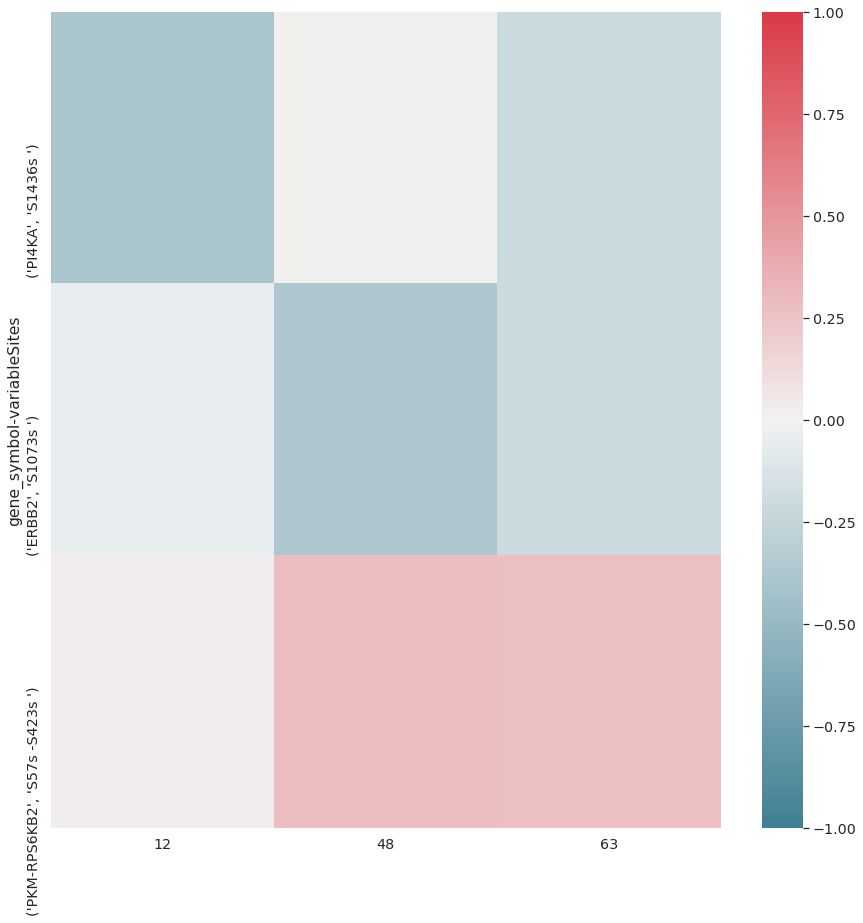

In [33]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
cmap.set_bad('#BDBDBD')
cmap.set_over('#9E031A')
cmap.set_under('#0C4A60')

thresh = 0.8
temp = proteomics_obj.regulator_coefficients.loc[proteomics_obj.regulator_coefficients.abs().idxmax()]
fig, axs = plt.subplots(figsize=(15, 15))
sns.heatmap(temp, cmap=cmap, vmin=-1, vmax=1, xticklabels=temp.columns, yticklabels=temp.index)

## Module plots

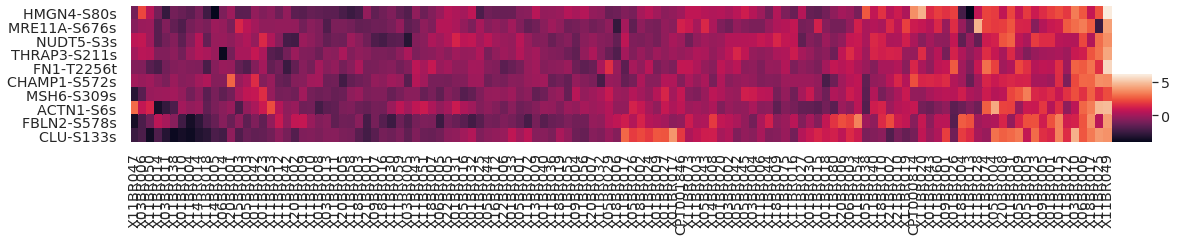

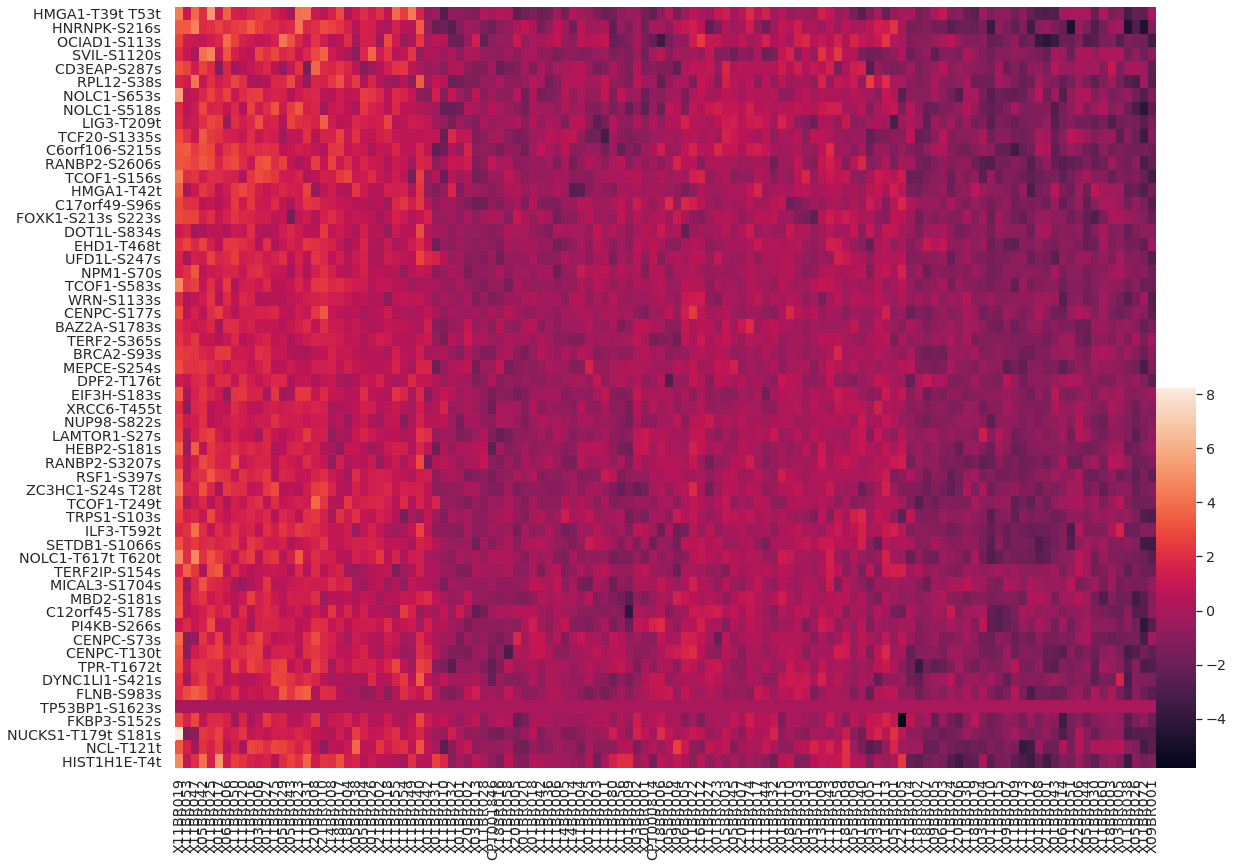

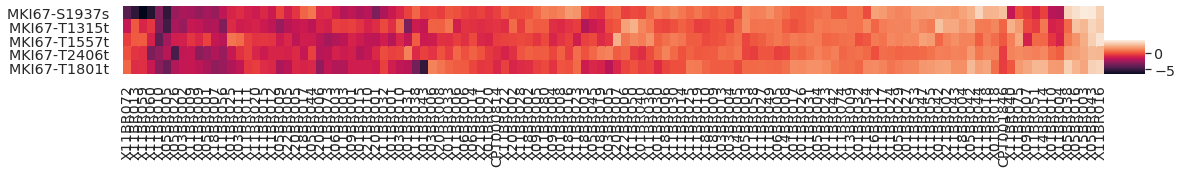

In [34]:
phdc.visualize.visualize_modules(proteomics_obj)

## Peptides

## collect_aa_sequences
This function takes in an `all_sites_modules_df` which is a DataFrame where each row represent a phosphosite and contains an ID referencing a fasta file.
The function uses this in combination with a fasta dictionary in order to fetch the peptide sequence surrounding each phosphosite. By default this will be 15 amino acids, where the central amino acid is the phospho site.

This function **has to be** run before running any of the other functions that perform analysis on peptides.

In [36]:
ref_fasta = phdc.datasets.load_data('GRCh38_latest_protein.faa', phdc.parsers.read_fasta)
dict_head(ref_fasta)

{'NP_000005.3': 'MGKNKLLHPSLVLLLLVLLPTDASVSGKPQYMVLVPSLLHTETTEKGCVLLSYLNETVTVSASLESVRGNRSLFTDLEAENDVLHCVAFAVPKSSSNEEVMFLTVQVKGPTQEFKKRTTVMVKNEDSLVFVQTDKSIYKPGQTVKFRVVSMDENFHPLNELIPLVYIQDPKGNRIAQWQSFQLEGGLKQFSFPLSSEPFQGSYKVVVQKKSGGRTEHPFTVEEFVLPKFEVQVTVPKIITILEEEMNVSVCGLYTYGKPVPGHVTVSICRKYSDASDCHGEDSQAFCEKFSGQLNSHGCFYQQVKTKVFQLKRKEYEMKLHTEAQIQEEGTVVELTGRQSSEITRTITKLSFVKVDSHFRQGIPFFGQVRLVDGKGVPIPNKVIFIRGNEANYYSNATTDEHGLVQFSINTTNVMGTSLTVRVNYKDRSPCYGYQWVSEEHEEAHHTAYLVFSPSKSFVHLEPMSHELPCGHTQTVQAHYILNGGTLLGLKKLSFYYLIMAKGGIVRTGTHGLLVKQEDMKGHFSISIPVKSDIAPVARLLIYAVLPTGDVIGDSAKYDVENCLANKVDLSFSPSQSLPASHAHLRVTAAPQSVCALRAVDQSVLLMKPDAELSASSVYNLLPEKDLTGFPGPLNDQDNEDCINRHNVYINGITYTPVSSTNEKDMYSFLEDMGLKAFTNSKIRKPKMCPQLQQYEMHGPEGLRVGFYESDVMGRGHARLVHVEEPHTETVRKYFPETWIWDLVVVNSAGVAEVGVTVPDTITEWKAGAFCLSEDAGLGISSTASLRAFQPFFVELTMPYSVIRGEAFTLKATVLNYLPKCIRVSVQLEASPAFLAVPVEKEQAPHCICANGRQTVSWAVTPKSLGNVNFTVSAEALESQELCGTEVPSVPEHGRKDTVIKPLLVEPEGLEKETTFNSLLCPSGGEVSEELSLKLPPNVVEESARASVSVLGDILGSAMQNTQNLLQMPYGCGEQNMVLFAPN

In [37]:
modules_of_interest = [12, 48, 63]

In [38]:
peptide_df = phdc.datasets.load_data('demo/BRCA_v5.2__module_site_df.csv')
peptide_df = peptide_df.loc[peptide_df.module.isin(modules_of_interest)]
peptide_df.head(2)

,gene_symbol,variable_sites_names,protein_id,variable_sites,module
4,ACTN1,S6s,NP_001123476.1,6,12
102,BAZ2A,S1783s,NP_038477.2,1783,63


In [39]:
proteomics_obj.collect_aa_sequences(
    all_sites_modules_df=peptide_df, 
    fasta=ref_fasta,
    module_col='module',
    var_sites_aa_col='variable_sites_names'
)

## analyze_aa_sequences
This function analyzes the amino acid enrichment at each position  for each module, as well as calculating the amino acid frequency.
That is, if we cut out 15 amino acids with `collect_aa_sequences`, we would get the enrichment and frequency for all amino acids for each of the 15 positions.
By default, it uses all phosphosites that are assigned to any module, as the background to compare amino acid frequencies to.

The `module_aa_enrichment` attribute contains signed p values for the enrichment of each amino acid at each position.
The `module_aa_freqs` attribute contains the amino acid frequencies at each position.

We use `phdc.visualize.visualize_aa` to make logo plots.

In [40]:
proteomics_obj.analyze_aa_sequences()

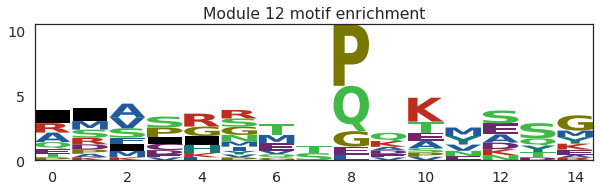

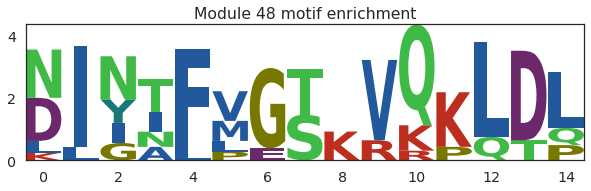

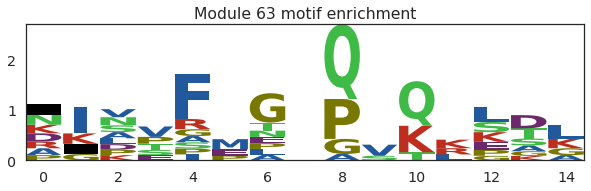

In [41]:
phdc.visualize.visualize_aa(
# we are taking the absolute p values here because that
# makes the plot easier to read
    {
        k:v.abs() for k,v in proteomics_obj.module_aa_enrichment.items()
    }
)

since most phosphosites are either T or S, these amino acids are not enriched compared to the background, which becomes evident when we look at the amino acid frequencies:

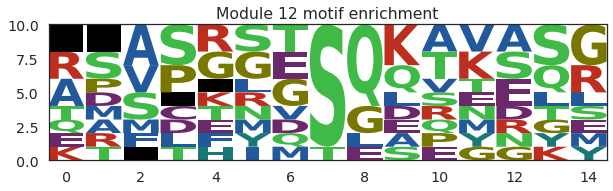

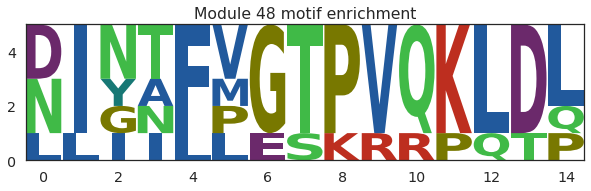

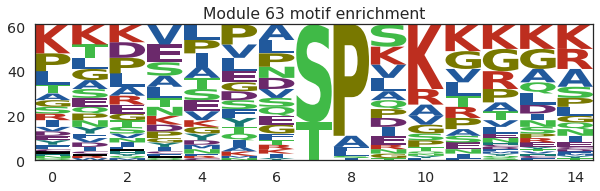

In [42]:
phdc.visualize.visualize_aa(
    {
        k:v.fillna(0) for k,v in proteomics_obj.module_aa_freqs.items()
    }
)

## ptm_set_enrichment
This function calculates the enrichment of phosphosites within each module within known phosphosite sets.
It sets the `.ptm_enrichment` attribute of our `ProteomicsData` object to a dictionary where each key is a module, and each value a `DataFrame` listing for each phosphosite set that had any overlap with the module, the p value and other info.

In [43]:
proteomics_obj.calculate_ptm_set_enrichment()

In [44]:
proteomics_obj.ptm_enrichment[63]\
.sort_values('Adjusted P-value').head(2)

,Site_set,Sites,Overlap,P-value,Adjusted P-value
Term,,,,,
KINASE-PSP_CDK2,"WRN_S1133,RPL12_S38,C17orf49_S96,SETDB1_S1066,...","WRN_S1133,C17orf49_S96,XRCC6_T455,RPL12_S38,DP...",12,0.053566,0.524731
KINASE-PSP_CDK1,"NOLC1_T607,TCOF1_S156,NUCKS1_S181,NOLC1_T610,C...","TCOF1_S156,TCOF1_S583,HMGA1_T42,NPM1_S70,HNRNP...",11,0.069964,0.524731


## analyze_aa_overlap
This function calculates for each pair of peptides in each module how many amino acids they have in common. This can be useful for figuring out if there is a subset of phosphosites that are very similar to each other.

In [45]:
proteomics_obj.analyze_aa_overlap()

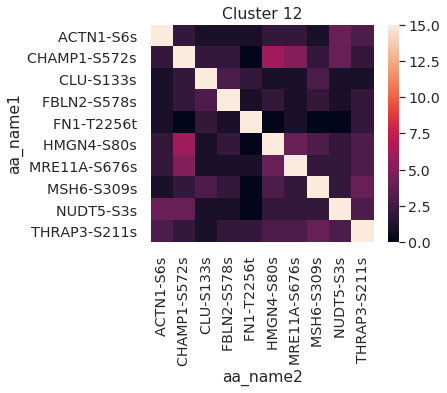

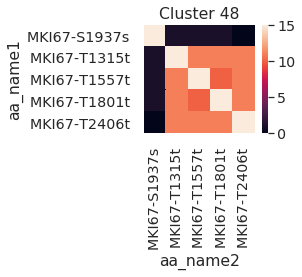

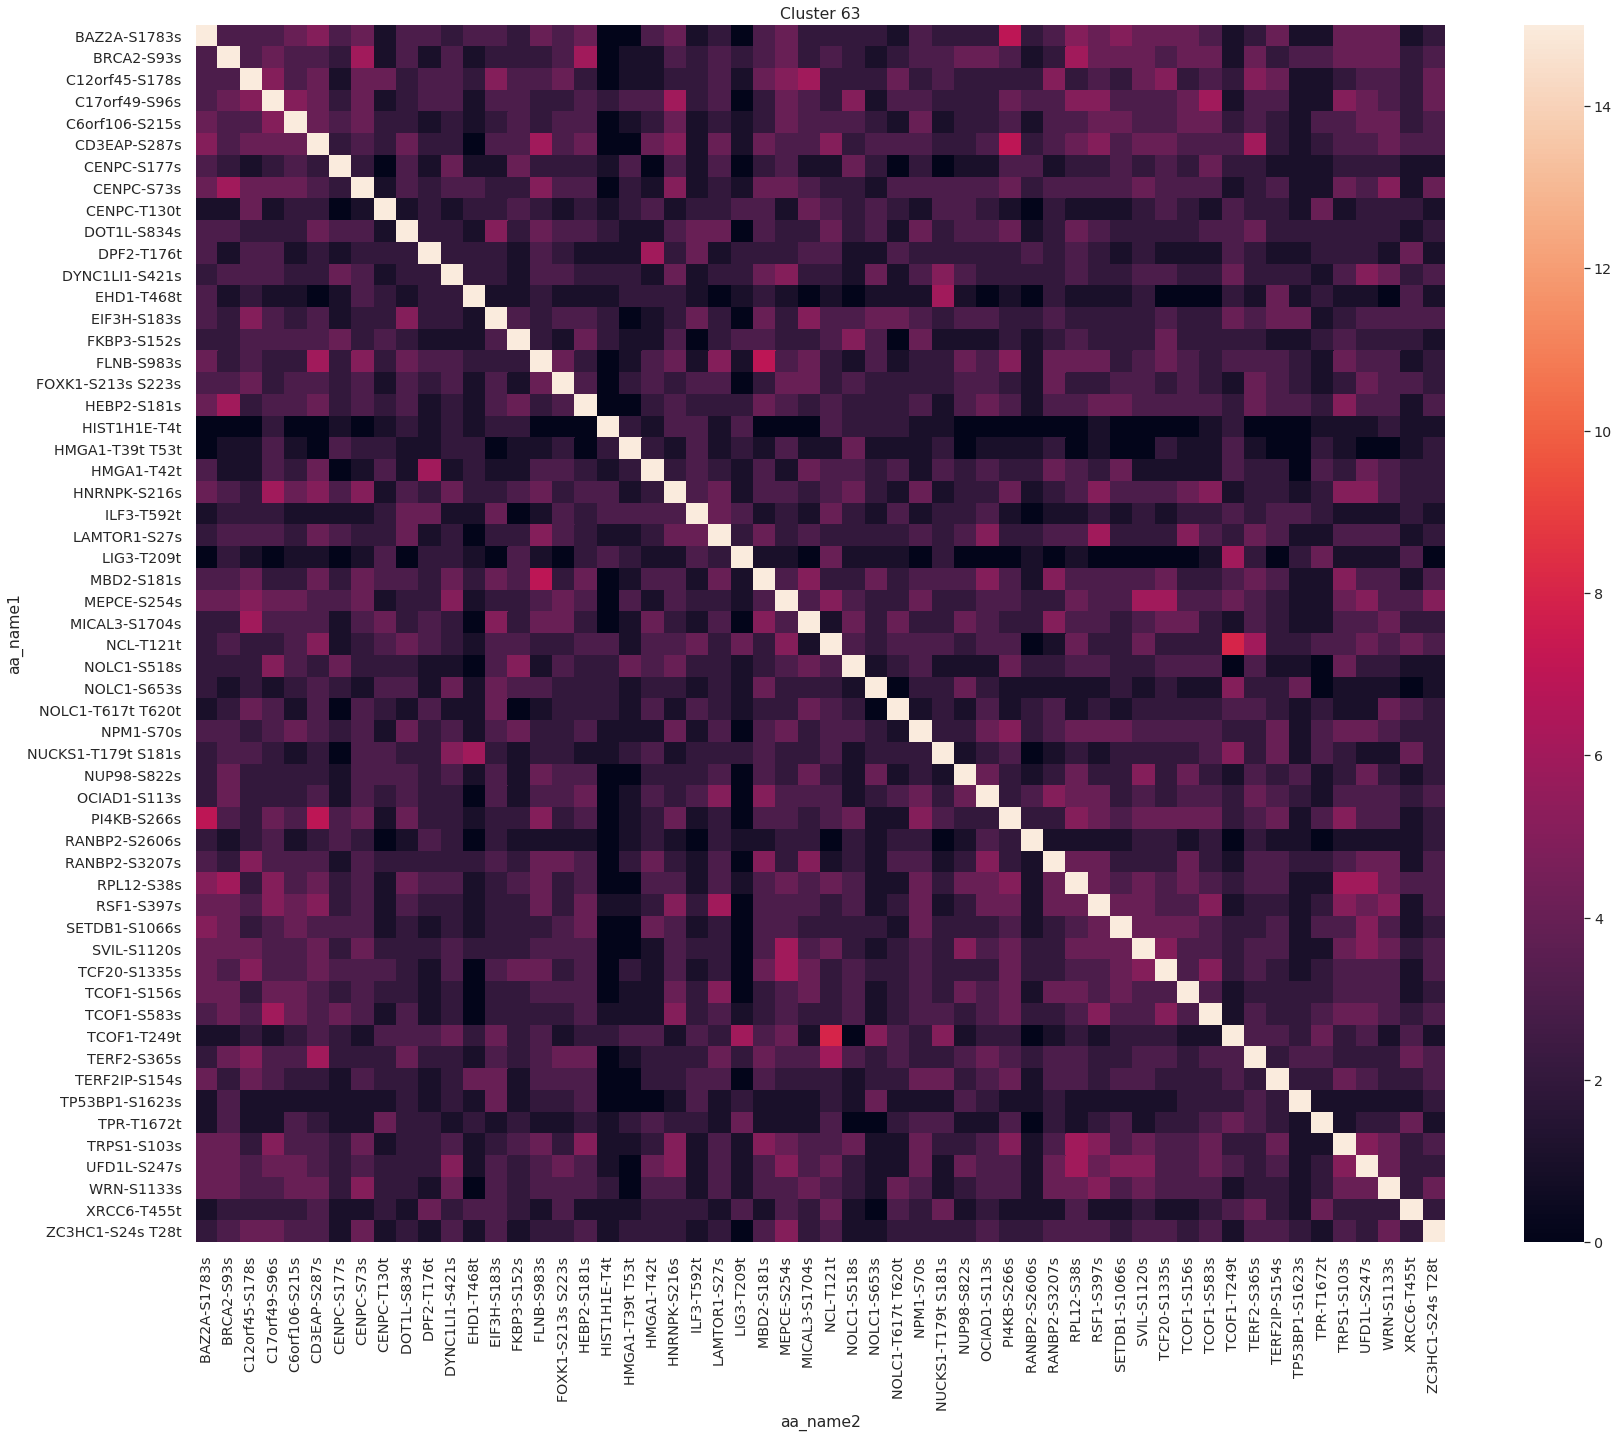

In [46]:
for cluster, aa_overlap_df in proteomics_obj.module_overlap_df_dict.items():
    fig_len = 0.5 * aa_overlap_df.shape[0]
    fig_width = 0.4 * aa_overlap_df.shape[0]
    fig = plt.figure(figsize=(fig_len, fig_width))
    sns.heatmap(
        aa_overlap_df, 
        xticklabels=aa_overlap_df.columns,
        yticklabels=aa_overlap_df.index
    )
    plt.title('Cluster %s' % cluster)
    plt.show()
    plt.close()